# Analysis of the dataset
In the following code we will analyze and understand the dataset and we'll pick one or many approaches to model a classifier and evaluate its performance. 

The first step will consist in understanding the main features of the dataset, if it is unbalanced, if there are many null values or if there are missing values to replace. Consequently, we'll adopt a strategy to transform the data in a useful format for the classfier. Based on the characteristics of the data we coul pick different classifiers and at the end evaluating their performance. 

In the last part we'll show the results with some final considerations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

path_data = '../archive.zip'
path_save_data = '../data/'

## Features and data understanding

*Why this particular dataset?* Browsing through all the possible Fraud Transaction Detection dataset, there were two main possibilities:
- [Santander Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset)
- [European Cardholders Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/versions/2?resource=download)

The second dataset has a good number of samples and almost 200 features but reading the related paper it is dedicated to analyze the user satisfaction and given the fact that there are *no understandable feature* I prefer to pick the first dataset.

If we display a full description of the choosen dataset we can figure out many useful things:
- V1, ..., V28 are 28 features results of the PCA process
- Time, Amount and Class are the only "unchanged" features

As the name says, ***Time*** contains the seconds elapsed between each transaction and the first transaction in the dataset. ***Amount*** describes the amount of cash transferred with the transaction and ***Class*** informs us if the transaction has been labeled as fraudulent (1) or not (0). All the features are **numerical.**

In [2]:
df = pd.read_csv(path_data, sep=',')
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


No null values are present inside the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Next, we check if there are duplicated fields. In the positive case we'll remove them because useless to our analysis. 

In [ ]:
if 'True' in (df.duplicated()):
    print("Duplicated fields")
else:
    print("No duplicated fields")

### Distribution fraud and non-fraud

We can see from the next graph how the fraud class is the minority class whereas the non-fraud is the majority one. This is a case of unbalanced dataset so we should apply measure to solve this issue.

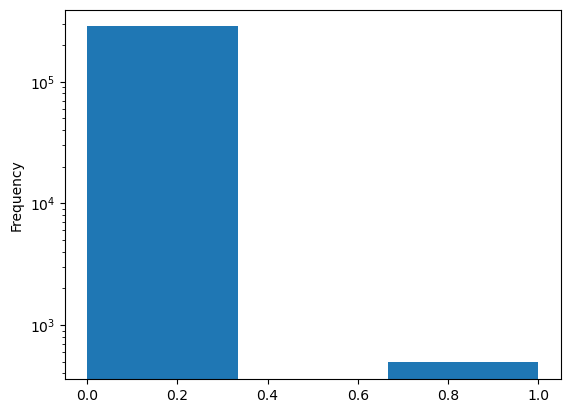

In [4]:
df["Class"].plot(kind="hist", bins=3, logy=True)
plt.show()

From the distribution of the time we can see that the transaction has been executed mainly around 50k and 150k seconds (13 hours and 41 hours) after the first transaction and that there is no uniform distribution, this is a normal behaviour because the data are extracted from a real scenario in which there is no specific pattern. We don't know when the monitoring of the data began so we cannot infer anything, the only information that we have is that the monitoring last two days.

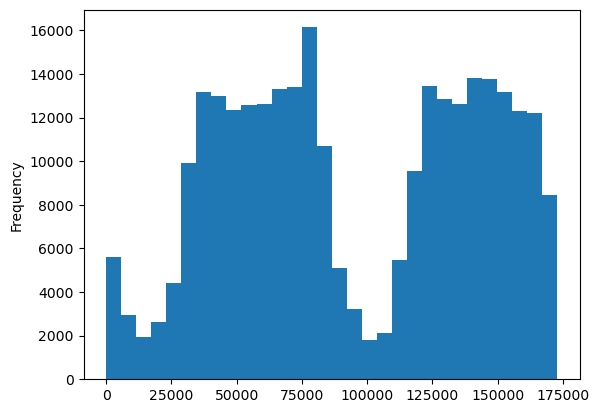

In [15]:
df["Time"].plot(kind="hist", bins=30)
plt.show()

The data are not gathered in a particular time, so we can avoid any additional modification.

Next, from the amount histogram we can see that we have some **outliers**, which should be managed in case we decide to use some particular "neighborhood" methods.

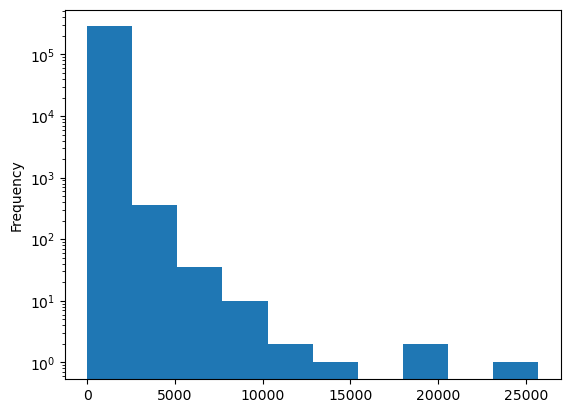

In [6]:
df["Amount"].plot(kind="hist", logy=True)
plt.show()

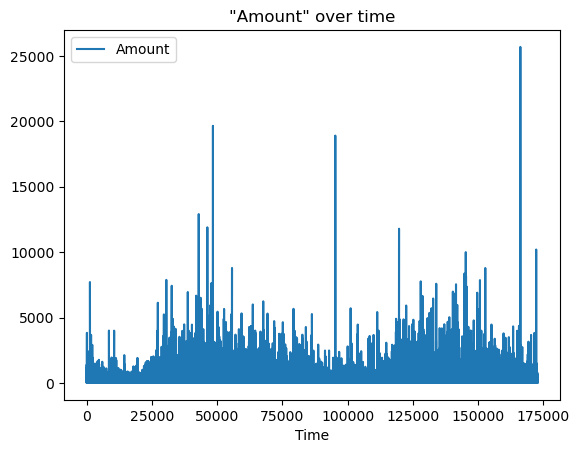

In [4]:
df[['Time', 'Amount']].set_index('Time').plot(title='"Amount" over time')
plt.show()

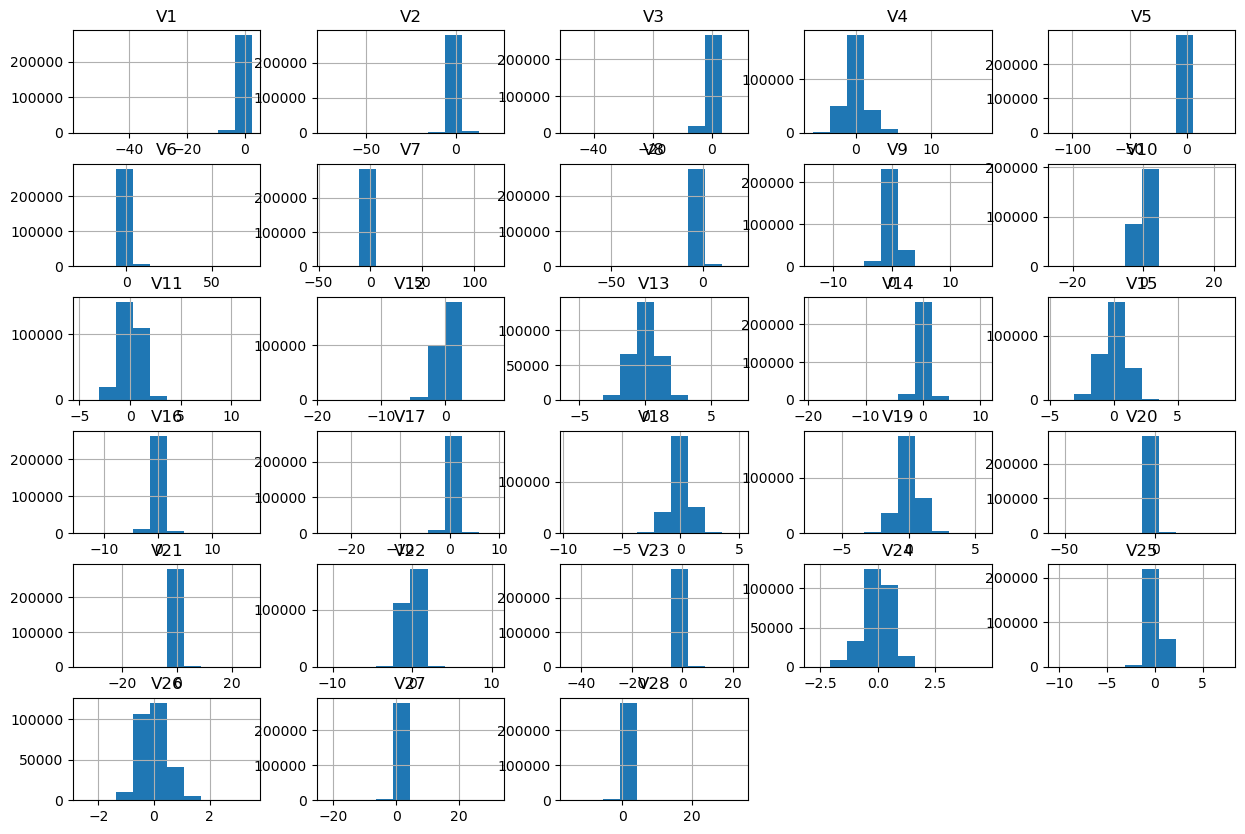

In [3]:
cols = df.columns.drop(['Time', 'Amount', 'Class'])
df[cols].hist(bins=10, figsize=(15, 10))
plt.show()

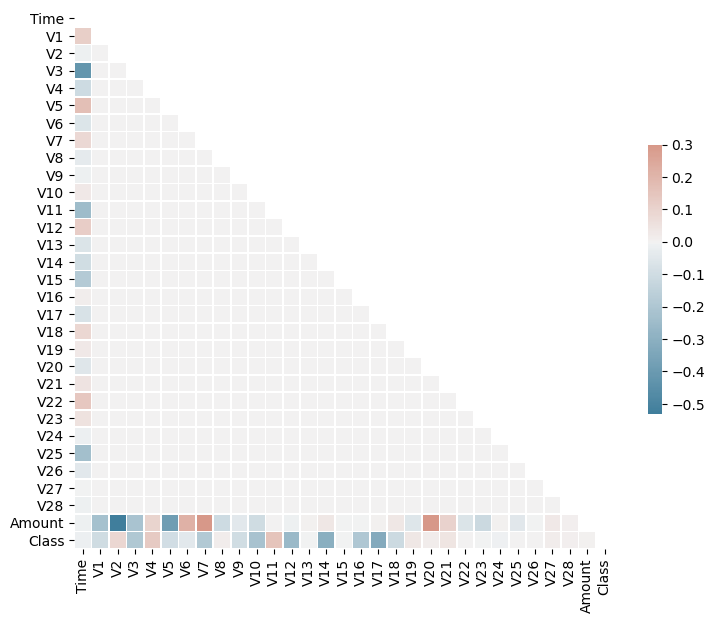

In [55]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Handle class imbalance
From the previous graph, we can observe the imbalance between the two classes "non-fraud", "fraud" where the positive class is the minority with respect to the negative one. To handle class imbalance there are two main approaches:

- **oversampling:** the positive class is "augmented" to obtain an equal distribution of the two classes
- **undersampling:** the negative class is reduced to obtain the same number of elements per classes

We'll analyze both the two approaches and we'll see the final results in both the cases.

In [3]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [4]:
print(len(df.columns))
print("X shape:", x.shape, " y shape:", y.shape)

31
X shape: (284807, 30)  y shape: (284807,)


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset in test and training set
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, train_size=0.7, \
                                                    random_state=0, stratify=y)

In [6]:
print("Train:", train_y.shape, " Test:", test_y.shape) 

Train: (199364,)  Test: (85443,)


The previous step is **ESSENTIAL** because it is one of the most pitfalls in sampling. In the resampling setting, there is a common pitfall that corresponds to *resample the entire dataset before splitting it into a train and a test partitions.* Note that it would be equivalent to resample the train and test partitions as well. Such of a processing leads to two issues:

- the model will not be tested on a dataset with class distribution similar to the real use-case. Indeed, by resampling the entire dataset, both the training and testing set will be potentially balanced while the model should be tested on the natural imbalanced dataset to evaluate the potential bias of the model;
- the resampling procedure might use information about samples in the dataset to either generate or select some of the samples. Therefore, we might use information of samples which will be later used as testing samples which is the typical data leakage issue.

Before diving into the different techniques of sampling, I'll list all the references that helps me choosing the right methods:
- [1]Yu, L. and Zhou, N., "Survey of Imbalanced Data Methodologies", 2021.

### Random sampling
The first sampling that we are gonna do will be the **random** one. We'll do both random undersampling and oversampling, this we'll give us a sort of treshold to which compare the other methods. Random sampling represents the basic method to apply when you're trying to fix class imbalance, next we'll explore more and more advanced and sophisticated techniques.

We'll explore other techniques because the random sampling can remove, in undersampling, useful data from the majority class, and add redundant data in oversampling leading to an overfitting.

In [7]:
count = Counter(train_y)
print("Distribution before sampling: 0:{} 1:{}".format(count[0], count[1]))

Distribution before sampling: 0:199020 1:344


In [8]:
from imblearn.over_sampling import RandomOverSampler

rand = RandomOverSampler(random_state=0) # seed np.random
orand_x, orand_y = rand.fit_resample(train_x, train_y)

print("Distribution: {}".format(Counter(orand_y)))

Distribution: Counter({0: 199020, 1: 199020})


In [9]:
from imblearn.under_sampling import RandomUnderSampler

rand = RandomUnderSampler(random_state=0) # seed np.random
urand_x, urand_y = rand.fit_resample(train_x, train_y)

print("Distribution: {}".format(Counter(urand_y)))

Distribution: Counter({0: 344, 1: 344})


### Oversampling (SMOTE)
Let's start with oversampling. We'll use the **Synthetic Minority Over-sampling Technique (SMOTE)** method; this allows for the generation of synthetic samples by interpolating the values that are present within the class subjected to oversampling. There are many techniques of oversampling in the literature, I wanted to pick this method because it was studied in class and it is one of the most used, an alternative to this could be **ADASYN**. 

The biggest problem of SMOTE is the *tendency to link inliers and outliers* leading to a sub-optimal result. For this reason we also employ a SMOTE variants called **borderlineSMOTE.**

#### SMOTE

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
smote_x, smote_y = smote.fit_resample(train_x, train_y)

smote_x.to_csv(path_save_data+'smote_x')
smote_y.to_csv(path_save_data+'smote_y')

print("Distribution after oversampling: {}".format(Counter(smote_y)))

Distribution after oversampling: Counter({0: 199020, 1: 199020})


#### borderline SMOTE
Source: *H. Han, W. Wen-Yuan, M. Bing-Huan, "Borderline-SMOTE: a new over-sampling method in imbalanced data sets learning", 2005.*

Borderline SMOTE has been proved (Source) to perform better with respect to SMOTE and RandomOversampling for this reason we will use it in this comparison. This variant of the SMOTE is different from existing over-sampling methods due to the fact that all the minority examples or a random subset of the minority class are not the elements that will be over-sampled, instead the **bordeline elements will be the one oversampled** (the one which truly affect the classification).

The explanation of the method will be given in the report. However, in this case we don't change the default settings, using 'borderline-1' instead of 2 due to the fact that the paper doesn't shows big differences in terms of TP rate and F value among the two.

In [13]:
from imblearn.over_sampling import BorderlineSMOTE
bsmote = BorderlineSMOTE(kind='borderline-1')
bsmote_x, bsmote_y = bsmote.fit_resample(train_x, train_y)

bsmote_x.to_csv(path_save_data+'bsmote_x')
bsmote_y.to_csv(path_save_data+'bsmote_y')

print("Distribution after oversampling: {}".format(Counter(bsmote_y)))

Distribution after oversampling: Counter({0: 199020, 1: 199020})


### Undersampling (Neighborhood cleaning rule)
Source: *Laurikkala, J., "Improving Identification of Difficult Small Classes by Balancing Class Distribution, 2001*

*What is the problem of undersampling?* Since the samples from the majority classes are removed, this method can potentially **ignore useful information from those removed samples.** Therefore, several under-sampling approaches are proposed to selectively remove samples from the majority class so that the information could be largely retained in the training data set. 

Why we pick a certain technique for undersampling? The choices were applying neighbours-based undersampler or tomek-links-based techniques, given the fact that we already study the neighbours technique for classification in class I decided to pick that. Among all the neighbour-based technique the **NeighborhoodCleaningRule** seems one of the best solution. In fact reading the paper (Source) of NCC we can see how it outperforms both RandomUnderSampling and OneSidedSelection, moreover it uses *EditedNearestNeighbours* to clean noisy data. From what the paper says, it suites very well with difficult small classes, as in our case.

We'll anyway compare NCC with RandomUnderSampling.

---

This method use a combination of ENN and other methods to remove noisy samples. 
From reference [2] the results show that Neighbordhood cleaning rule performs better than One-sided selection on more than ten datasets

In [9]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

# The 'all' parameter is the less conservative one
ncr = NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=3, kind_sel='all', threshold_cleaning=0.5)
ncr_x, ncr_y = ncr.fit_resample(train_x, train_y)

ncr_x.to_csv(path_save_data+'ncr_x')
ncr_y.to_csv(path_save_data+'ncr_y')

print("Distribution: {}".format(Counter(ncr_y)))

Distribution: Counter({0: 198125, 1: 344})


In [10]:
print("Elements removed: ", len(train_y)-len(ncr_y))

Elements removed:  895


Given the fact that the undersampling method does't remove a lot of samples, for a design property, we can classify these data using a cost-sensitive approach, in particular **Weighted Random Forest**, which works pretty well on unbalanced data and then we can compare the result of using the same technique on the original dataset, to see if the undersampling really remove noisy samples.

Why is NCR designed to remove only few samples? We can say that this method is more oriented to *data cleaning* than data reduction:
- Quality of classification doesn't depend solely on the size of the class, other characteristics as noise should be considered
- It is difficult to maintain the original classification accuracy while the data is being reduced

### Combination over and under sampling
Source: *Gustavo EAPA Batista, Ana LC Bazzan, and Maria Carolina Monard. Balancing training data for automated annotation of keywords: a case study. In WOB, 10–18. 2003.*

As we said before the SMOTE can generate noisy data due to fact that it links inliers and outliers data. This issue can be solved by cleaning the space resulting from oversampling. A possible way is using the *Edited Nearest Neighbours* to do so, this mechanism is implemented in the **SMOTEENN.**

We will run this method only once and then we'll save the results due to the fact that this process is **very computationally demanding.**

In [14]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
smote_enn_x, smote_enn_y = smote_enn.fit_resample(train_x, train_y)

smote_enn_x.to_csv(path_save_data+'smote_enn_x')
smote_enn_y.to_csv(path_save_data+'smote_enn_y')

print("Distribution after oversampling: {}".format(Counter(smote_enn_y)))

Distribution after oversampling: Counter({1: 190618, 0: 181766})


## Classification methods
The classification phase is subdivided into two subcategories:
- Model selection and learning phase
- Predicting phase

We'll use multiple classifiers due to the fact that we still have unbalanced data but also balanced one.

https://scikit-learn.org/stable/_static/ml_map.png

For unbalanced data (original dataset and NCR) we pick **Weighted Random Forest** which can be adapted to these kind of data and **Weighted SVM.**

For balanced data (ROS, RUS, SMOTE, borderlineSMOTE, SMOTEENN) I avoided K-NN because it was extensively used in sampling and maybe this can led to a sort of overfitting (?), instead I pick **SVM** and **Logistic Regression** due to the fact that they are very efficient and robust even with large datasets, **Decision Trees** due to its high sensitivity so I am curios to see how it will perform. I choose these three methods because they are the most suited for numerical attributes.

### Unbalanced: Weighted Random Forest 
Source:
- *M. Shahhosseini, Guiping Hu, Improved Weighted Random Forest for Classification Problems}, 2021.*

.....

Following the first reference we'll choose the right **weight** for the minority class optimizing the *area under the ROC curve (AUC).*

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import math

print("Test :", Counter(test_y))

Test : Counter({0: 85295, 1: 148})


In [11]:
# Load datasets
ncr_x = pd.read_csv(path_save_data+'ncr_x', index_col=0)
ncr_y = pd.read_csv(path_save_data+'ncr_y', index_col=0)
ncr_y = ncr_y.Class.values

# train_x, train_y

In [12]:
# Check SHAPE
print("Train : ", train_x.shape, train_y.shape, Counter(train_y))
print("NCR   : ", ncr_x.shape, ncr_y.shape, Counter(ncr_y))

Train :  (199364, 30) (199364,) Counter({0: 199020, 1: 344})
NCR   :  (198469, 30) (198469,) Counter({0: 198125, 1: 344})


In [58]:
rf = RandomForestClassifier()
rf.get_params() # usually 100 trees

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Original dataset

In [21]:
%%time

# Find the optimal weight
best = [0, 0]
for w in range(10, 80, 10):
    rf_model = RandomForestClassifier(class_weight={0:1, 1:w})
    rf_model.fit(train_x, train_y)
    y_pred_rf = rf_model.predict(test_x)
    
    print("|----- Weight equal to {} -----|".format(w))
    r_score = roc_auc_score(test_y, y_pred_rf)
    if max(r_score, best[1]) == r_score:
        best[0] = w
        best[1] = r_score
    print("\_____ AUC: {} _______________/\n".format(r_score))
    
print("The best couple weight-auc is ({},{})".format(best[0], best[1]))

|----- Weight equal to 10 -----|
\_____ AUC: 0.8547062816964336 _______________/

|----- Weight equal to 20 -----|
\_____ AUC: 0.8580846600748119 _______________/

|----- Weight equal to 30 -----|
\_____ AUC: 0.8614630384531904 _______________/

|----- Weight equal to 40 -----|
\_____ AUC: 0.8547062816964336 _______________/

|----- Weight equal to 50 -----|
\_____ AUC: 0.8547062816964336 _______________/

|----- Weight equal to 60 -----|
\_____ AUC: 0.858090522083136 _______________/

|----- Weight equal to 70 -----|
\_____ AUC: 0.8648355548232446 _______________/

The best couple weight-auc is (70,0.8648355548232446)
CPU times: user 17min 19s, sys: 223 ms, total: 17min 20s
Wall time: 17min 21s


In [13]:
# Fitting and prediction
w = 70

rf_model = RandomForestClassifier(class_weight={0:1, 1:w})
rf_model.fit(train_x, train_y)
y_pred_rf = rf_model.predict(test_x)
np.save(path_save_data+'orig_pred_y', y_pred_rf)

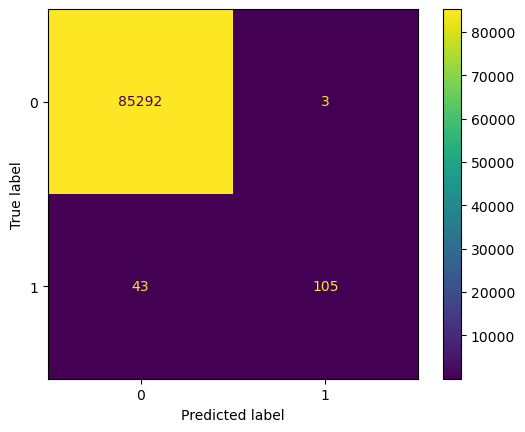

In [14]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [15]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9994616293903538
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.71      0.82       148

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443



#### Neighborhood cleaning rule

In [28]:
%%time

# Find the optimal weight
best = [0, 0]
for w in range(10, 80, 10):
    rf_model = RandomForestClassifier(class_weight={0:1, 1:w})
    rf_model.fit(ncr_x, ncr_y)
    y_pred_rf = rf_model.predict(test_x)
    
    print("|----- Weight equal to {} -----|".format(w))
    r_score = roc_auc_score(test_y, y_pred_rf)
    if max(r_score, best[1]) == r_score:
        best[0] = w
        best[1] = r_score
    print("\_____ AUC: {} _______________/\n".format(r_score))
    
print("The best couple weight-auc is ({},{})".format(best[0], best[1]))

|----- Weight equal to 10 -----|
\_____ AUC: 0.8614630384531904 _______________/

|----- Weight equal to 20 -----|
\_____ AUC: 0.858090522083136 _______________/

|----- Weight equal to 30 -----|
\_____ AUC: 0.8547062816964336 _______________/

|----- Weight equal to 40 -----|
\_____ AUC: 0.8547062816964336 _______________/

|----- Weight equal to 50 -----|
\_____ AUC: 0.8580846600748119 _______________/

|----- Weight equal to 60 -----|
\_____ AUC: 0.8547062816964336 _______________/

|----- Weight equal to 70 -----|
\_____ AUC: 0.8547004196881095 _______________/

The best couple weight-auc is (10,0.8614630384531904)
CPU times: user 17min 12s, sys: 156 ms, total: 17min 12s
Wall time: 17min 13s


In [16]:
# Fitting and prediction
w = 10

rf_model = RandomForestClassifier(class_weight={0:1, 1:w})
rf_model.fit(ncr_x, ncr_y)
y_pred_rf = rf_model.predict(test_x)
np.save(path_save_data+'ncr_pred_y', y_pred_rf)

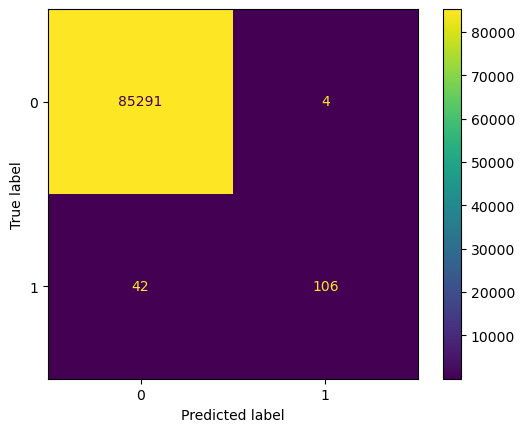

In [17]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [18]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9994616293903538
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.72      0.82       148

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



### Balanced dataset classification

(ROS, RUS, SMOTE, borderlineSMOTE, SMOTEENN)

In [60]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Load datasets
# orand_x, orand_y
# urand_x, urand_y

smote_x = pd.read_csv(path_save_data+'smote_x', index_col=0)
smote_y = pd.read_csv(path_save_data+'smote_y', index_col=0)
smote_y = smote_y.Class.values

bsmote_x = pd.read_csv(path_save_data+'bsmote_x', index_col=0)
bsmote_y = pd.read_csv(path_save_data+'bsmote_y', index_col=0)
bsmote_y = bsmote_y.Class.values

smote_enn_x = pd.read_csv(path_save_data+'smote_enn_x', index_col=0)
smote_enn_y = pd.read_csv(path_save_data+'smote_enn_y', index_col=0)
smote_enn_y = smote_enn_y.Class.values

### SGD Classifier
SGD Classifier is a linear classifier (SVM, logistic regression, a.o.) optimized by the SGD. I used SGD classifier for efficiency (computation and memory) and also to minimize the loss (??) function of LR and SVM.

In [ ]:
from sklearn.pipeline import Pipeline
lr = SGDClassifier(loss="log_loss", penalty="l2")
estimators = [('lr', lr)]
pipe = Pipeline(estimators)
pipe

pipe.fit(Xtr,ytr)
y_pred = pipe.predict(Xte)
# save prediction

In [50]:
# Scaling of the features is needed when using the SGD Classifier
# Using RobustScaler() due to its robustness againt outliers
scaler = RobustScaler()
scaler.fit(orand_x)
norand_x = scaler.transform(orand_x) ## Put here the right dataset
ntest_x = scaler.transform(test_x)

In [55]:
%%time
clf = SGDClassifier(loss="log_loss", penalty="l2") # Logistic Regression
clf.fit(norand_x, orand_y)
y_pred_lr = clf.predict(ntest_x)
np.save(path_save_data+'orand_lr_pred_y', y_pred_lr)

CPU times: user 1.22 s, sys: 12.1 ms, total: 1.23 s
Wall time: 1.22 s


In [ ]:
def classify(train_x, train_y, test_x, test_y):

    t = PrettyTable(
        ['Name', 'Confusion Matrix', 'Accuracy', 'Precision', 'Recall', 'F1'] )

    for name, clf in zip( names, classifiers ):

        # fitting the classifier
        clf.fit( train_x, train_y )
        # testing the classifier over the testing set
        predictions = clf.predict( test_x )
        # computing metrics over the testing set classification
        _accuracy = format(accuracy_score(test_y,predictions))
        _precision = format(precision_score(test_y,predictions))
        _recall = format(recall_score(test_y,predictions))
        _f1 = format(f1_score(test_y,predictions))
        _matrix = confusion_matrix(test_y,predictions)

        fpr, tpr, _ = roc_curve( test_y, predictions )
        roc_auc = auc( fpr, tpr )
        plt.figure()
        lw = 2
        plt.plot( fpr, tpr, color='darkturquoise', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc )
        plt.plot( [0, 1], [0, 1], color='navy', lw=lw, linestyle='--' )
        plt.xlim( [0.0, 1.0] )
        plt.ylim( [0.0, 1.05] )
        plt.xlabel( 'False Positive Rate' )
        plt.ylabel( 'True Positive Rate' )
        plt.title( name+' ROC curve' )
        plt.legend( loc="lower right" )
        plt.show()

        # saving the trained algorithm in the trained_models directory
        model = 'trained_models/'+name+'.model'
        pickle.dump(clf, open(model, 'wb'))


        t.add_row(
            [colored( name, 'blue' ), _matrix, _accuracy[0:5], _precision[0:5], _recall[0:5], _f1[0:5] 
            ])

        t.add_row( ['', '', '', '', '', ''] )
    print( t )

In [67]:
from prettytable import PrettyTable

def res_table(name, test_y, predictions):
    t = PrettyTable(['Name', 'Confusion Matrix', 'Accuracy', 'Precision', 'Recall', 'F1'])

    _accuracy = format(accuracy_score(test_y,predictions))
    _precision = format(precision_score(test_y,predictions))
    _recall = format(recall_score(test_y,predictions))
    _f1 = format(f1_score(test_y,predictions))
    _matrix = confusion_matrix(test_y,predictions)

    t.add_row([name, _matrix, _accuracy[0:5], _precision[0:5], _recall[0:5], _f1[0:5]])
    #t.add_row( ['', '', '', '', '', ''] )
    
    print(t)

In [68]:
res_table('RandOverSampl Logistic Regression', test_y, y_pred_lr)

+-----------------------------------+------------------+----------+-----------+--------+-------+
|                Name               | Confusion Matrix | Accuracy | Precision | Recall |   F1  |
+-----------------------------------+------------------+----------+-----------+--------+-------+
| RandOverSampl Logistic Regression |  [[83803  1492]  |  0.982   |   0.081   | 0.891  | 0.148 |
|                                   |  [   16   132]]  |          |           |        |       |
|                                   |                  |          |           |        |       |
+-----------------------------------+------------------+----------+-----------+--------+-------+


In [ ]:
clf = SGDClassifier(loss="log", penalty="l2") # Logistic Regression
clf = SGDClassifier(loss="hinge", penalty="l2") # Linear SVM

# set the right parameters and choose the right method

In [47]:
from scipy.stats import shapiro

cols = df.columns
alpha = 0.05

for i in range(0, len(cols)):
    stat, p = shapiro(df[cols[i]])

    if p > alpha:
         print(cols[i], ': gaussian')
    else:
         print(cols[i], ': not gaussian')

/home/ranxerox/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Time : not gaussian
V1 : not gaussian
V2 : not gaussian
V3 : not gaussian
V4 : not gaussian
V5 : not gaussian
V6 : not gaussian
V7 : not gaussian
V8 : not gaussian
V9 : not gaussian
V10 : not gaussian
V11 : not gaussian
V12 : not gaussian
V13 : not gaussian
V14 : not gaussian
V15 : not gaussian
V16 : not gaussian
V17 : not gaussian
V18 : not gaussian
V19 : not gaussian
V20 : not gaussian
V21 : not gaussian
V22 : not gaussian
V23 : not gaussian
V24 : not gaussian
V25 : not gaussian
V26 : not gaussian
V27 : not gaussian
V28 : not gaussian
Amount : not gaussian
Class : not gaussian


### Linear SVC

In [ ]:
lsvc = LinearSVC(random_state=0, tol=1e-5) # set the parameters

### Random Forest

In [16]:
clf = RandomForestClassifier()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Random Oversampling

In [24]:
%%time
clf = RandomForestClassifier()
clf.fit(orand_x, orand_y)
y_pred_rf = clf.predict(test_x)
np.save(path_save_data+'orand_rf_pred_y', y_pred_rf)

CPU times: user 2min 25s, sys: 16 ms, total: 2min 25s
Wall time: 2min 25s


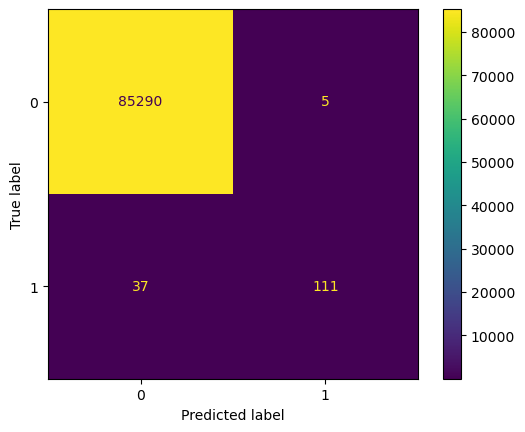

In [25]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [26]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9995084442259752
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.75      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



#### Random Undersampling

In [21]:
%%time
clf = RandomForestClassifier()
clf.fit(urand_x, urand_y)
y_pred_rf = clf.predict(test_x)
np.save(path_save_data+'urand_rf_pred_y', y_pred_rf)

CPU times: user 785 ms, sys: 2 µs, total: 785 ms
Wall time: 783 ms


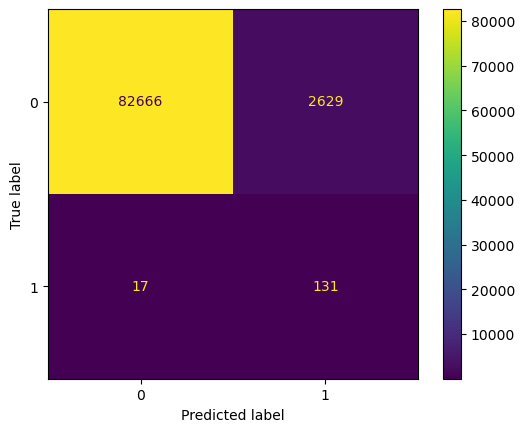

In [22]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [23]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9690319862364384
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85295
           1       0.05      0.89      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443



#### SMOTE

In [30]:
%%time
clf = RandomForestClassifier()
clf.fit(smote_x, smote_y)
y_pred_rf = clf.predict(test_x)
np.save(path_save_data+'smote_rf_pred_y', y_pred_rf)

CPU times: user 5min 27s, sys: 36 ms, total: 5min 27s
Wall time: 5min 27s


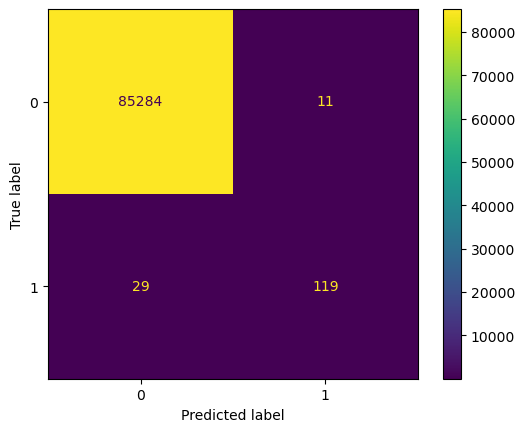

In [31]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [32]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9995318516437859
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.80      0.86       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



#### Borderline SMOTE

In [33]:
%%time
clf = RandomForestClassifier()
clf.fit(bsmote_x, bsmote_y)
y_pred_rf = clf.predict(test_x)
np.save(path_save_data+'bsmote_rf_pred_y', y_pred_rf)

CPU times: user 4min 45s, sys: 120 ms, total: 4min 45s
Wall time: 4min 47s


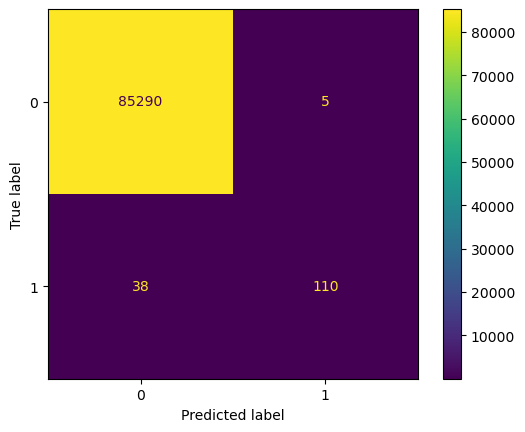

In [34]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [35]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9994967405170698
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.74      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



#### SMOTEENN

In [36]:
%%time
clf = RandomForestClassifier()
clf.fit(smote_enn_x, smote_enn_y)
y_pred_rf = clf.predict(test_x)
np.save(path_save_data+'smoteenn_rf_pred_y', y_pred_rf)

CPU times: user 5min 11s, sys: 128 ms, total: 5min 11s
Wall time: 5min 13s


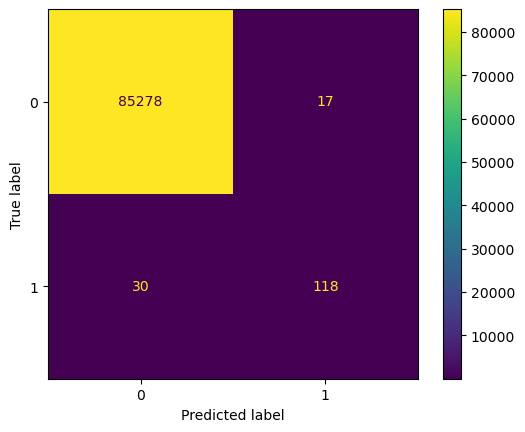

In [37]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf)
plt.show()

In [38]:
print(accuracy_score(test_y, y_pred_rf))
print(classification_report(test_y, y_pred_rf))

0.9994499256814484
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.80      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
convertere tutto a pipeline??